# Load Packages

In [1]:
import pandas as pd
import numpy as np
from collections import Counter

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
# Categorical data correlations
from dython.nominal import associations
# Modeling
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay


In [2]:
# Get data 
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [3]:
# Manipulate data
df_train.columns = df_train.columns.str.lower()
df_test.columns = df_test.columns.str.lower()

In [4]:
# Set style and colors
sns.set(style = 'white')

# EDA

In [5]:
# Data is highly imbalanced, with an imbalance ratio of 7.
counter = Counter(df_train.response)
print('Estimate: %.3f' % (counter[0] / counter[1]))

# No Nas.
print(df_train.isna().sum())
(df_train == 0).any()

Estimate: 7.159
id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64


id                      False
gender                  False
age                     False
driving_license          True
region_code              True
previously_insured       True
vehicle_age             False
vehicle_damage          False
annual_premium          False
policy_sales_channel    False
vintage                 False
response                 True
dtype: bool

In [6]:
df_train[['age', 'driving_license', 'previously_insured', 'annual_premium', 'vintage']].describe() 

,age,driving_license,previously_insured,annual_premium,vintage
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,38.822584,0.997869,0.458210,30564.389581,154.347397
std,15.511611,0.046110,0.498251,17213.155057,83.671304
min,20.000000,0.000000,0.000000,2630.000000,10.000000
25%,25.000000,1.000000,0.000000,24405.000000,82.000000
50%,36.000000,1.000000,0.000000,31669.000000,154.000000
75%,49.000000,1.000000,1.000000,39400.000000,227.000000
max,85.000000,1.000000,1.000000,540165.000000,299.000000


# 3 important points:
1. Most customers do not have a vehicle insurance, which might make it hard to distinguish between those who need one.
2. Most customeres have a driving license. 
3. There is no one who has been more than 1 year with the company.

Text(0, 0.5, '')

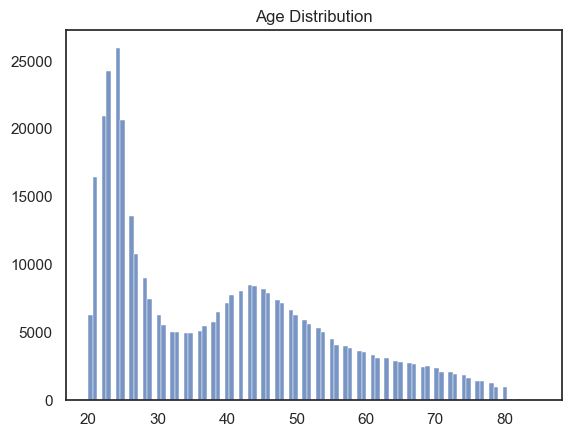

In [7]:
sns.histplot(data = df_train, x = 'age')
plt.title("Age Distribution")
plt.xlabel("") 
plt.ylabel("") 

Here we have a bimodal distribution.
1) There are significantlly more customers between their 20-30, then it drops
and then again 2) there is a slow increase in the late 30s and early 40s.

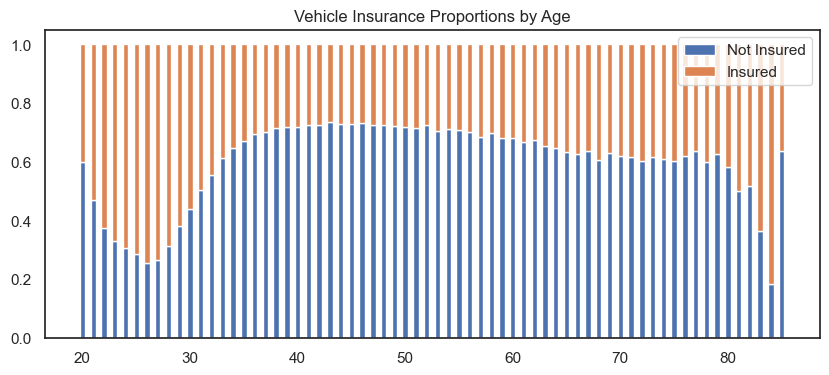

In [8]:
new_df = (df_train.groupby('age')['previously_insured'].value_counts(normalize = True).unstack())
fig, ax = plt.subplots(figsize = (10, 4))
ax.bar(new_df.index, new_df[0], label = "Not Insured", width = 0.5) 
ax.bar(new_df.index, new_df[1], bottom = new_df[0], label = "Insured", width = 0.5) 
plt.title("Vehicle Insurance Proportions by Age")
plt.legend()

Also between 20-30 most have a vehicle insurance already.
The number starts dropping from 30s on, with a very small increase from mid 50s on.
Does that have anything to do with gender?

Text(0.5, 1.0, 'Gender distribution by Age')

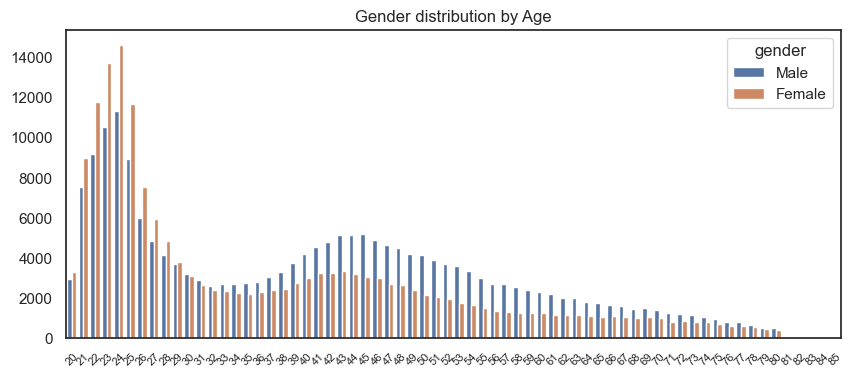

In [15]:
fig, ax = plt.subplots(figsize = (10, 4))
sns.countplot(data = df_train, x = 'age', hue = 'gender')
plt.xticks(size = 8, rotation = 45)
plt.xlabel("")
plt.ylabel("")
plt.title("Gender distribution by Age")

The age distribution is the same across genders.
The difference is that there are more female customers in the age group 20-30. 
Then in older age, relatively to men, there are less women. 

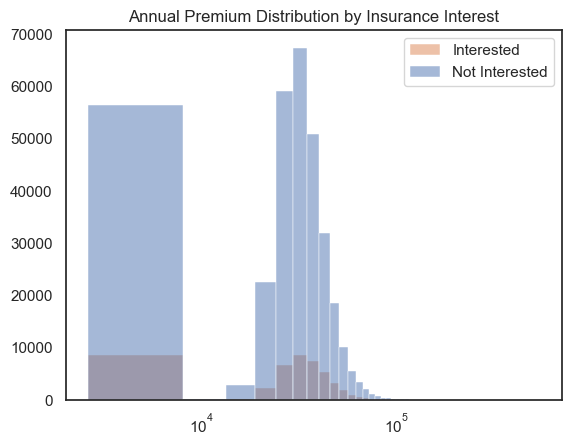

In [20]:
sns.histplot(data = df_train, x = 'annual_premium', hue = 'response', bins = 100)
plt.xscale('log')
plt.xlabel("")
plt.ylabel("")
plt.title("Annual Premium Distribution by Insurance Interest")
legend_labels = ['Interested', 'Not Interested']
plt.legend(labels = legend_labels)

Very interesting. We've got around 15% of the customers paying the same annual premium?

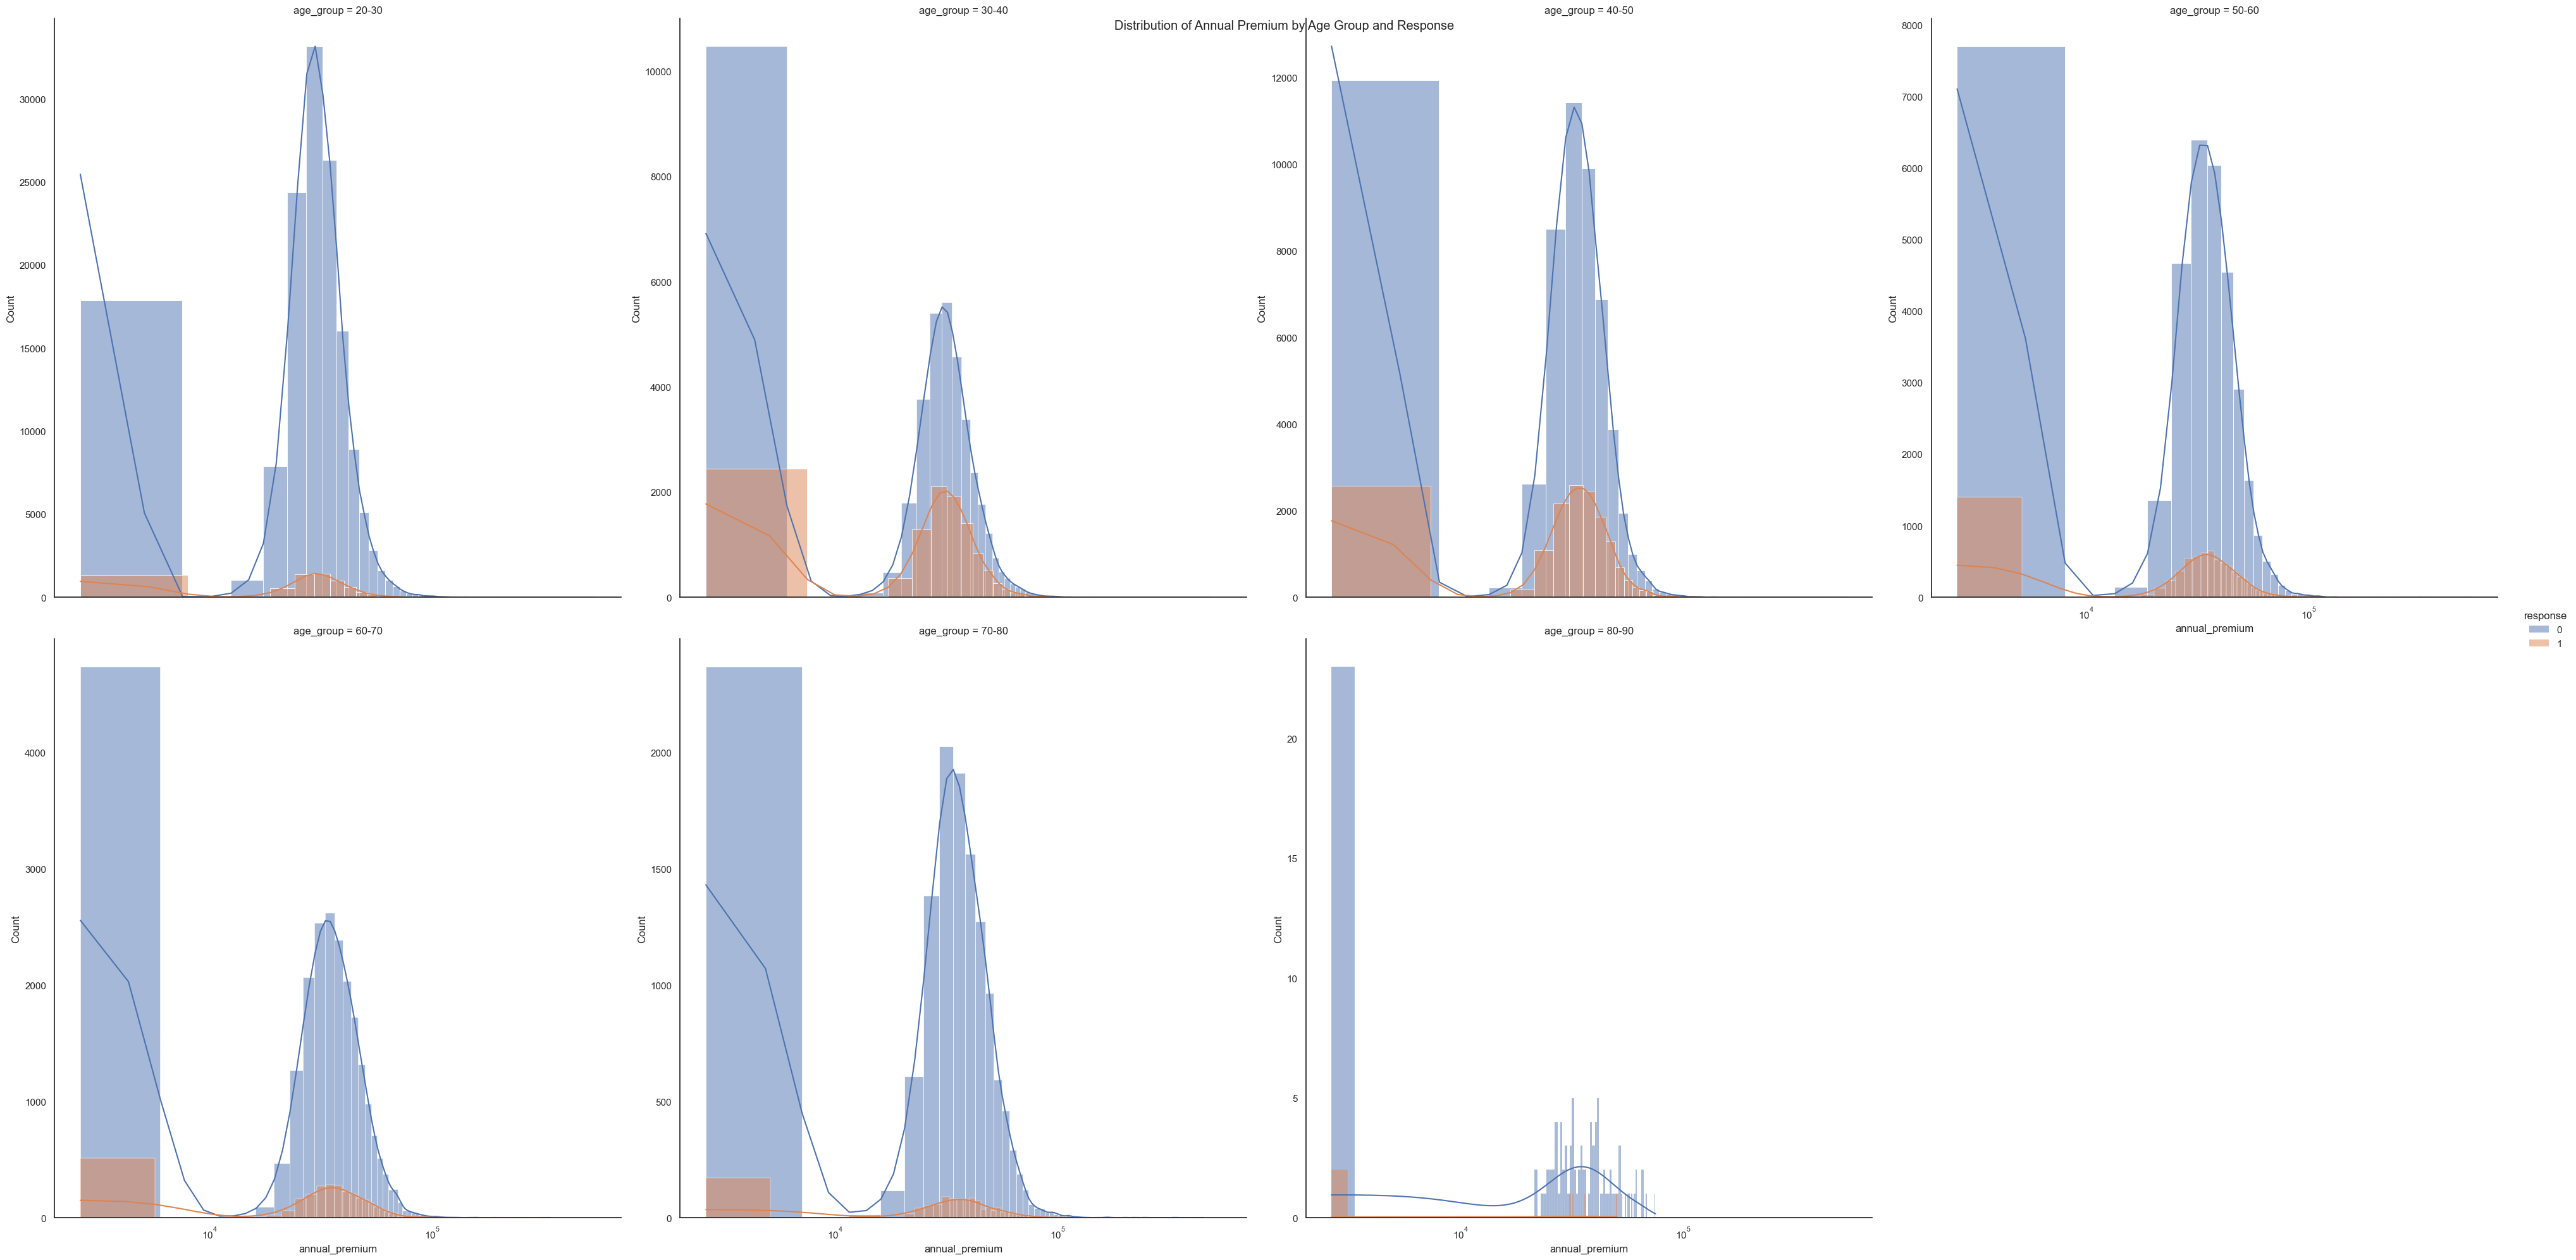

In [25]:
df_train['age_group'] = pd.cut(df_train['age'], bins = [20, 30, 40, 50, 60, 70, 80, 90], labels = ['20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90'])
g = sns.FacetGrid(df_train, col = 'age_group', hue = 'response', col_wrap = 4, height = 10, sharey = False)
g.map(sns.histplot, 'annual_premium', bins = 100, kde = True)
g.set(xscale = 'log')
g.fig.suptitle('Annual Premium Distribution by Age Group and Response')
g.add_legend()

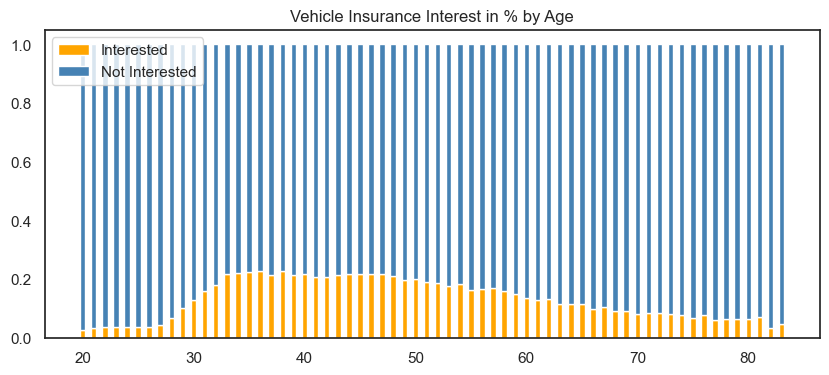

In [27]:
new_df = df_train.groupby('age')['response'].value_counts(normalize=True).unstack()
fig, ax = plt.subplots(figsize = (10, 4))
ax.bar(new_df.index, new_df[1], label = "Interested", width = 0.5, color = "orange") 
ax.bar(new_df.index, new_df[0], bottom = new_df[1], label = "Not Interested", width = 0.5, color = "steelblue") 
plt.title("Vehicle Insurance Interest in % by Age")
plt.legend()

Higher increase around late 20s and early 30s. Then it slowly decreases with time from 50s on.
That makes sense, the lifespan is shorter, therefore the insurance need is not felt as much.

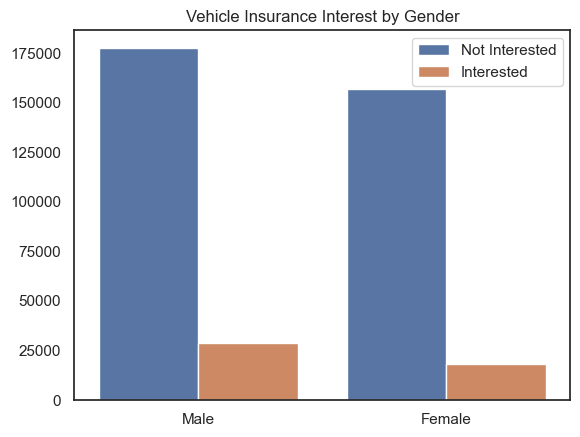

In [28]:
sns.countplot(data = df_train, x = 'gender', hue = 'response')
plt.xlabel("")
plt.ylabel("")
plt.title("Vehicle Insurance Interest by Gender")
plt.legend(labels = ['Not Interested', 'Interested'])

We've got more males customers in the data, that could affect the higher rate.

## Correlations
For numeric data, using Spearman correlation, as we mostly see non-linear relationships in the data.

<AxesSubplot: >

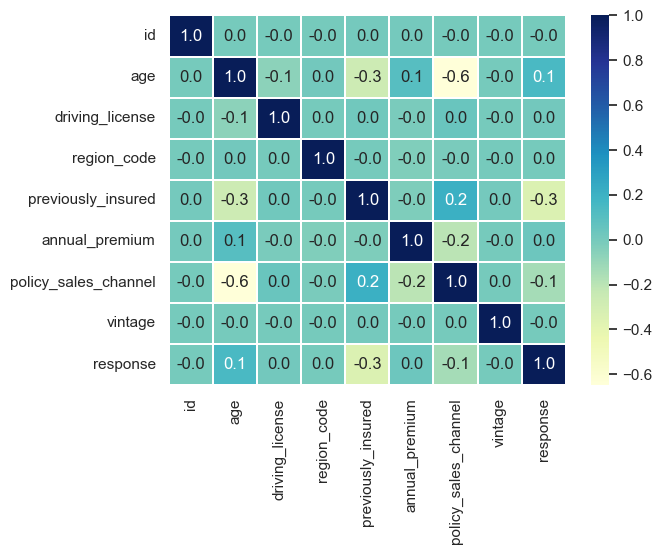

In [29]:
corr = df_train.corr(numeric_only = True, method = 'spearman')
sns.heatmap(corr,  annot = True, fmt = '.1f', linewidths = .1, cmap = "YlGnBu")

The data suggests an inverse relationship between customer age and the likelihood of having vehicle insurance. 
Additionally, there appears to be a negative association between customer age and the sales channel, 
although the dataset lacks detailed explanations for each sales channel, making it challenging to interpret the exact nature of this relationship.

Moreover, considering customers with prior insurance coverage, it's reasonable to expect a lower demand for additional insurance (response = 0), as they are already insured.

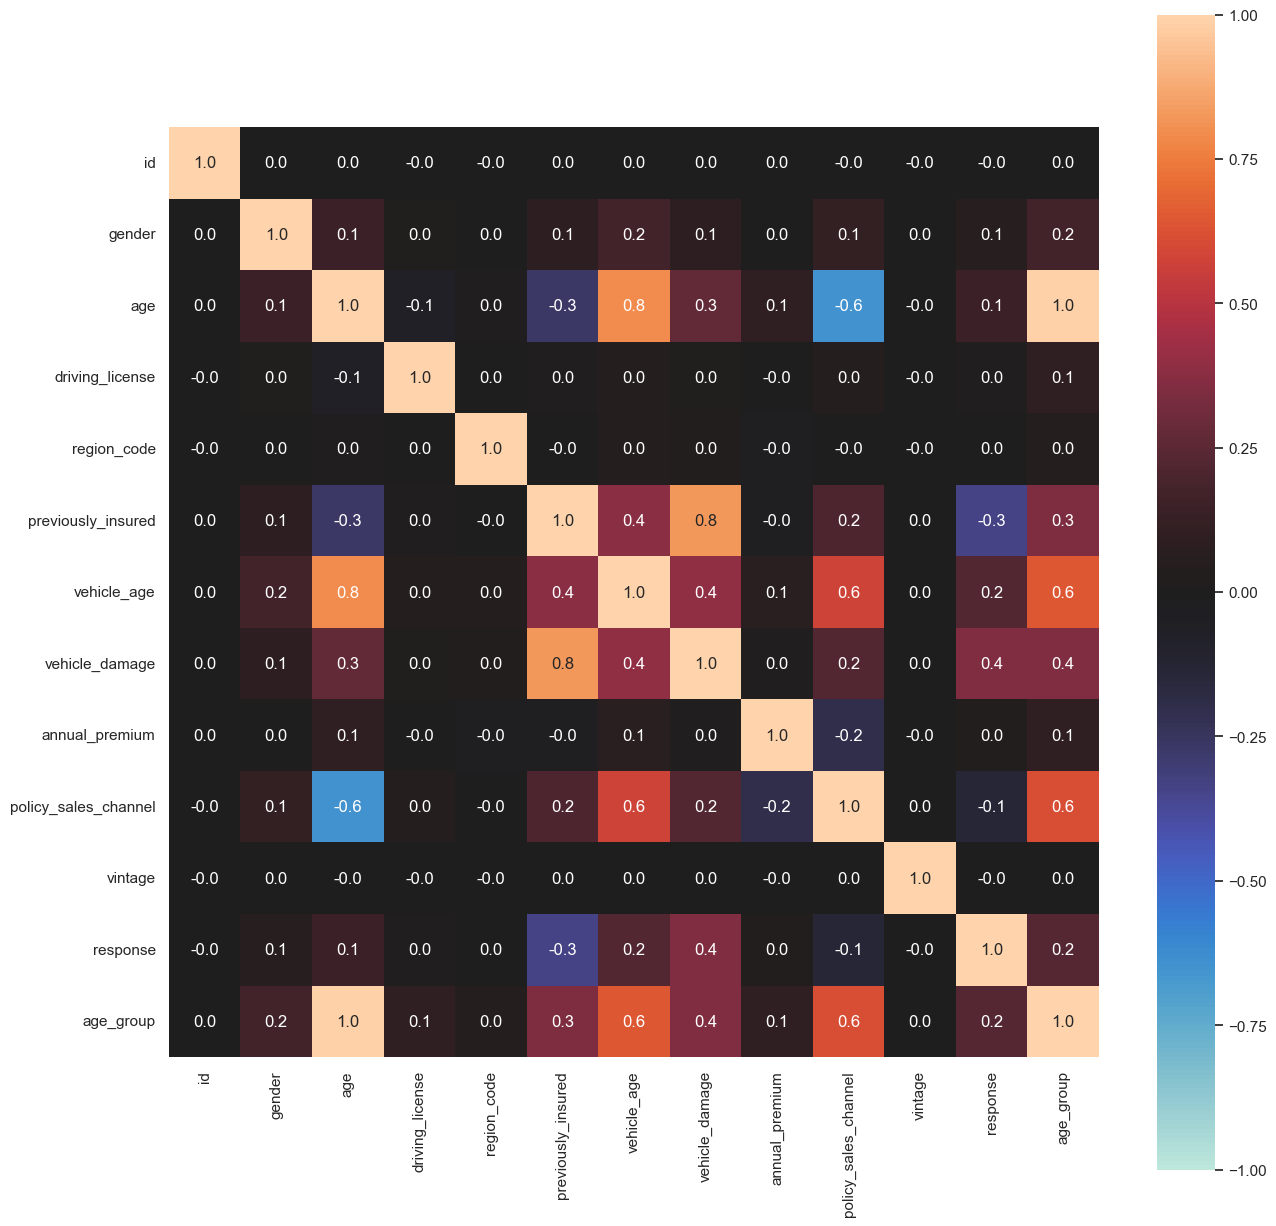

{'corr':                             id    gender       age  driving_license  \
 id                    1.000000  0.000999  0.000963        -0.000564   
 gender                0.000999  1.000000  0.145545         0.018374   
 age                   0.000963  0.145545  1.000000        -0.064802   
 driving_license      -0.000564  0.018374 -0.064802         1.000000   
 region_code          -0.000155  0.000604  0.012923         0.000533   
 previously_insured    0.002457  0.081932 -0.268065         0.014969   
 vehicle_age           0.001380  0.166770  0.791632         0.040232   
 vehicle_damage        0.001507  0.091586  0.267534         0.016622   
 annual_premium        0.002897  0.003673  0.099440        -0.013822   
 policy_sales_channel -0.002363  0.111159 -0.648227         0.045131   
 vintage              -0.000630  0.002517 -0.001618        -0.000852   
 response             -0.001368  0.052440  0.144360         0.010155   
 age_group             0.003833  0.171172  0.984924     

In [54]:
# Now all together with categorical data.
associations(df_train, num_num_assoc = 'spearman', fmt = '.1f', figsize = (15, 15))

To that, we can see that the vehicle damage and vehicle age affect the response.
However, let's not rush. We can see that there is also correlation between being previously insured and 
vehicle age or vehicle damage. And being previously insured is also correlated with age, as we have observed before.

# Feature Engineering

In [30]:
# Age vs. vehicle age
df_train['vehicle_age'] = df_train['vehicle_age'].apply(lambda x: 3 if x == '> 2 Years' else (2 if x == '1-2 Year' else 1))
df_train['age_vehicle_age_interaction'] = df_train['age'] * df_train['vehicle_age']
df_test['vehicle_age'] = df_test['vehicle_age'].apply(lambda x: 3 if x == '> 2 Years' else (2 if x == '1-2 Year' else 1))
df_test['age_vehicle_age_interaction'] = df_test['age'] * df_test['vehicle_age']

# Age vs. channel
df_train['age_channel_interaction'] = df_train['age'] * df_train['policy_sales_channel']
df_test['age_channel_interaction'] = df_test['age'] * df_test['policy_sales_channel']

# Binning age
cut_bins = np.arange(10, 90, 10)
df_train['age_group'] = pd.cut(df_train['age'], bins = cut_bins)
df_test['age_group'] = pd.cut(df_test['age'], bins = cut_bins)

# Coding vehicle damage 
mapping_vehicle_damage = {'No': 0, 'Yes': 1}
df_train['vehicle_damage'] = df_train['vehicle_damage'].replace(mapping_vehicle_damage)
df_test['vehicle_damage'] = df_test['vehicle_damage'].replace(mapping_vehicle_damage)

# Pre-processing

In [31]:
# Encoding age groups
df_train = pd.get_dummies(df_train, columns = ['age_group'], drop_first = True)
df_test = pd.get_dummies(df_test, columns = ['age_group'], drop_first = True)

# Choosing features
columns_to_drop = ['id','gender', 'age', 'driving_license', 'vehicle_age', 'policy_sales_channel', 'region_code',  'vintage', 'annual_premium', 'response']
X = df_train.drop(columns = columns_to_drop).values.reshape(-1, 10)
y = df_train['response']

# Quick sanity check ... and it looks good.
print(X.shape, y.shape)

# Finally, splitting data by making sure the distribution across the test data is the same as in the training data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = df_train.response, random_state = 1)

print('Positive cases % in the Test set: ', round(100 * len(y_test[y_test == 1]) / len(y_test), 3), '%')
print('Positive cases % in Train set: ', round(100 * len(y_train[y_train == 1]) / len(y_train), 3), '%')

(381109, 10) (381109,)
Positive cases % in the Test set:  12.256 %
Positive cases % in Train set:  12.256 %


# Modeling

In [32]:
# Define class weights for Random Forest 
count_class_1 = df_train['response'].value_counts()[0]
count_class_2 = df_train['response'].value_counts()[1]
ratio = count_class_1 / count_class_2

In [33]:
# Configure all models
models = []
models.append(("Random Forest", RandomForestClassifier(n_estimators = 100, random_state = 1)))
models.append(("Weighted Random Forest", RandomForestClassifier(n_estimators = 100, class_weight = {1:ratio, 0:1}, random_state = 1)))
# We have a dataset with a aprox. 7 to 100 ratio in the minority to majority classes, but I will
# set the weight to 3 to not hurt the precision and avoid overfitting.
models.append(("Weighted Catboost", CatBoostClassifier(iterations = 10, 
                                                       custom_metric = "F1", 
                                                       learning_rate = 0.01,
                                                       depth = 8, 
                                                       scale_pos_weight = 3, 
                                                       l2_leaf_reg = 5, 
                                                       random_state = 1)))


In [34]:
# Create Stratified K-fold cross validation to evaluate models
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)

# Evaluating models

In [35]:
results = []
names = []
for name, model in models:
    result = cross_val_score(model, X_train, y_train, cv = cv, scoring = 'roc_auc', n_jobs = -1, verbose = 1)
    names.append(name)
    results.append(result)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  8.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  9.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   53.7s finished


0:	learn: 0.6888833	total: 182ms	remaining: 1.63s
1:	learn: 0.6846747	total: 258ms	remaining: 1.03s
2:	learn: 0.6805698	total: 333ms	remaining: 776ms
3:	learn: 0.6765610	total: 400ms	remaining: 599ms
4:	learn: 0.6726146	total: 493ms	remaining: 493ms
5:	learn: 0.6687160	total: 587ms	remaining: 391ms
6:	learn: 0.6649081	total: 681ms	remaining: 292ms
7:	learn: 0.6611741	total: 760ms	remaining: 190ms
8:	learn: 0.6575380	total: 839ms	remaining: 93.2ms
9:	learn: 0.6540034	total: 888ms	remaining: 0us


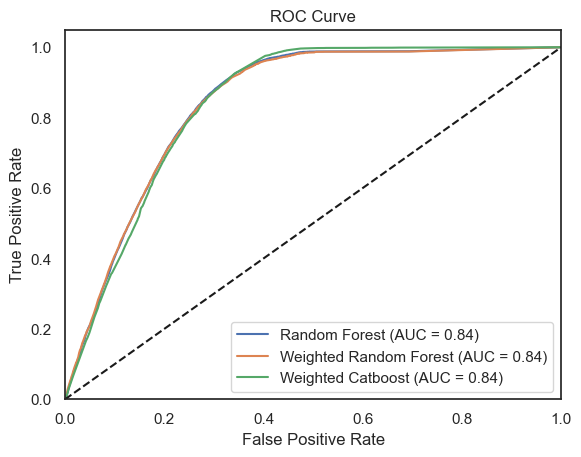

In [36]:
# ROC and AUC
for name, model in models:
    model.fit(X_train, y_train)
    y_pred_probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc = 'lower right')

All models perform similar. 
Let's check now the metrics and apply a Confusion Matrix.

In [37]:
# Generating the Classification Report
for name, model in models:
    print(f'Processing {name}...')  # For debugging

    y_pred = model.predict(X_test)
    print(f'Classification Report for {name}:\n')
    print(classification_report(y_test, y_pred, zero_division = 1))
    print("=" * 60)

Processing Random Forest...
Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.88      0.99      0.93     66880
           1       0.37      0.03      0.05      9342

    accuracy                           0.88     76222
   macro avg       0.62      0.51      0.49     76222
weighted avg       0.82      0.88      0.82     76222

Processing Weighted Random Forest...
Classification Report for Weighted Random Forest:

              precision    recall  f1-score   support

           0       0.98      0.69      0.81     66880
           1       0.28      0.89      0.43      9342

    accuracy                           0.71     76222
   macro avg       0.63      0.79      0.62     76222
weighted avg       0.89      0.71      0.76     76222

Processing Weighted Catboost...
Classification Report for Weighted Catboost:

              precision    recall  f1-score   support

           0       0.95      0.78      0.86     66880
 

Catboost is the fastest and performs the best in terms of F1-score.
Nevertheless, none of the models can easily distinguish customers that are interested in insurance with those who are not.

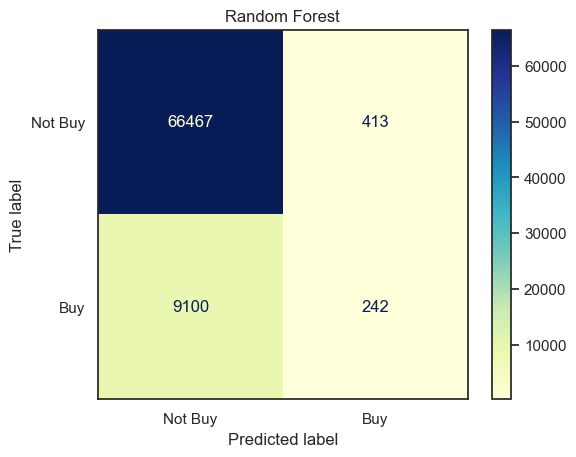

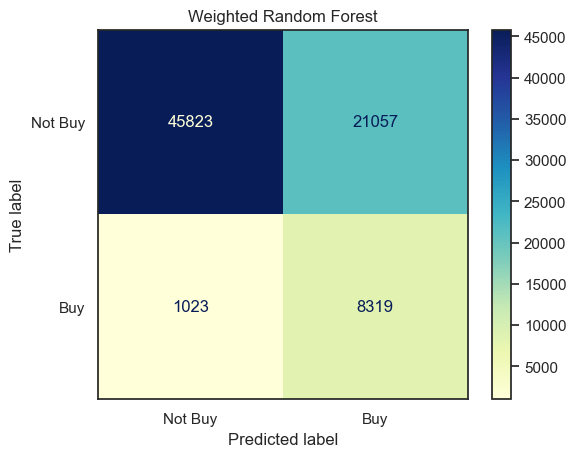

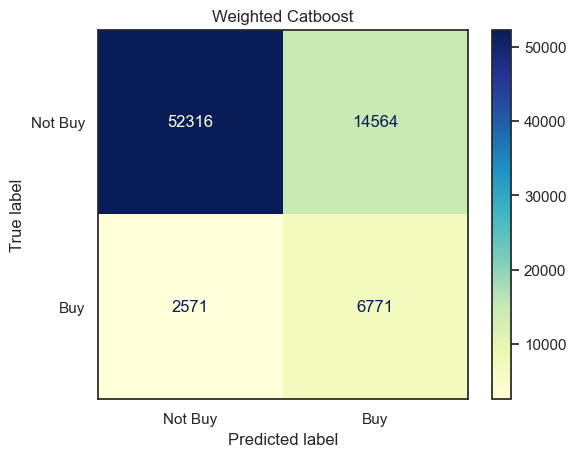

In [39]:
for name, model in models:
    predictions = model.predict(X_test)
    cm = confusion_matrix(y_test, predictions)
    ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Not Buy', 'Buy']).plot(cmap = "YlGnBu")
    plt.title(f"{name}")

The False Positives are still in abundance, but the least with Catboost.

Text(0.5, 1.0, 'Histogram of Predicted Probabilities for Class 1')

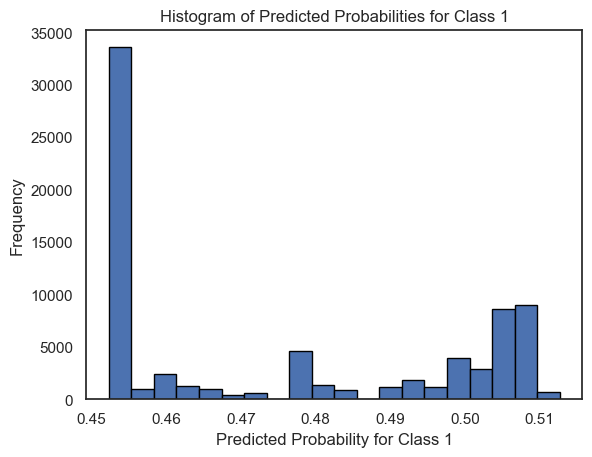

In [40]:
name, model = models[2]
y_pred = model.predict_proba(X_test)
positive_probs = y_pred[:, 1]
plt.hist(positive_probs, bins = 20, edgecolor = 'black')
plt.xlabel('Predicted Probability for Class 1')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities for Class 1')

We can see that the model is not confident in its results.

Text(0.5, 1.0, 'Histogram of Predicted Probabilities for Class 1')

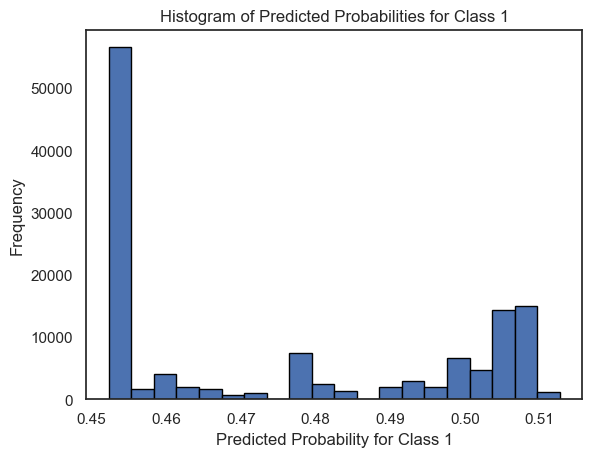

In [42]:
columns_to_drop2 = columns_to_drop.remove("response")
X_real_test = df_test.drop(columns = columns_to_drop).values.reshape(-1, 10)
y_pred = model.predict_proba(X_real_test)
positive_probs = y_pred[:, 1]
plt.hist(positive_probs, bins = 20, edgecolor = 'black')
plt.xlabel('Predicted Probability for Class 1')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities for Class 1')

In [44]:
from sklearn.model_selection import GridSearchCV

# Define a parameter grid for grid search
param_grid = {
    'depth': [6, 8, 10],
    'l2_leaf_reg': [3, 5, 7],
    'scale_pos_weight': [1, 3, 5]
}

# Create CatBoostClassifier
catboost = CatBoostClassifier(custom_metric="F1", random_state=1)

# Initialize GridSearchCV
grid_search = GridSearchCV(catboost, param_grid, cv = 3, scoring = 'f1', n_jobs = -1, verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
